## This is an implementation of a convnet that *tries* to reconstruct attended audio from EEG signal. 

This version is built from an encoder (trained in another notebook called EEGnet_CNN_autoencoder) that is supposed to *know* dense representations of the EEG features. Here we add this pre-trained encoder, freeze its weights and try to learn to reconstruct the audio based on the dense hidden representations of the EEG signal. So far, (at lease in its current form, the net fails to achieve any reconstruction at all. We get overfitting, that's it. ANY SUGGESTIONS ARE VERY WELCOME!

In [1]:
# we first define the autoencoder's architecture:

# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt

# def Encoder():
#     input_img = Input(shape=(60, 800, 1))  # adapt this if using `channels_first` image data format   
#     e1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
#     e2 = MaxPooling2D((2, 2), padding='same')(e1)
#     e3 = Conv2D(8, (3, 3), activation='relu', padding='same')(e2)
#     e4 = MaxPooling2D((3, 2), padding='same')(e3)
#     e5 = Conv2D(8, (10, 10), activation='relu', padding='same')(e4)
#     e6 = MaxPooling2D((2, 2), padding='same')(e5)
#     return Model(input_img, e6)

def Decoder():
    input_img = Input(shape=(5, 100, 8))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(16, (10, 10), activation='relu', padding='same')(input_img)
    d2 = UpSampling2D((1, 2))(d1)
#     d3 = BatchNormalization(axis=1)(d2)
    d4 = Dropout(0.5)(d2)
    d5 = Conv2D(32, (5, 5), activation='relu', padding='same')(d4)
    d6 = UpSampling2D((1, 2))(d5)
#     d7 = BatchNormalization(axis=1)(d6)
    d8 = Dropout(0.5)(d6)
    d9 = Conv2D(32, (4, 4), activation='relu', padding='same')(d8)
    d10 = UpSampling2D((1, 2))(d9)
#     d11 = BatchNormalization(axis=1)(d10)
    d12 = Dropout(0.5)(d10)
    d13 = Conv2D(16, (3, 3), activation='relu', padding='same')(d12)     # !!!!!!!!!!!!!!!!relu
    d13a = LeakyReLU(alpha=0.01)(d13)
    d14 = MaxPooling2D((5, 1))(d13a)
    d15 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d14)  # !!!!!!!!!!!!!!!!relu
    return Model(input_img, d15)


Using TensorFlow backend.


In [ ]:
# define input to the model:
x = Input(shape=(60, 800, 1))

# load the pre-trained encoder
# enc = load_model("/home/amplifier/home/models/CNN_encoder_model.h5")
enc = load_model("/home/amplifier/home/NEW_DL/models/CNN_encoder_model.h5")

enc.trainable = False ############################################################################!!!!!!!!!!!!!!!!!@@@
enc.compile(optimizer='adadelta', loss='binary_crossentropy')

# make the model:
model = Model(x, Decoder()(enc(x)))

# compile the model:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [39]:
# SEE INSIDE THE ENCODER AND DECODER:

enc.summary()
Decoder().summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 800, 1)        0         
_________________________________________________________________
model_1 (Model)              (None, 5, 100, 8)         7728      
Total params: 7,728
Trainable params: 0
Non-trainable params: 7,728
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 5, 100, 8)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 5, 100, 16)        12816     
_________________________________________________________________
up_sampling2d_34 (UpSampling (None, 5, 200, 16)        0         
_________________________________________________________________
dropout_

In [40]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
# mat_contents = sio.loadmat("EEG_data_KOS_1+2.mat") #('EEG_data.mat')
mat_contents = sio.loadmat("EEG_big4CNN.mat") #('EEG_data.mat')
X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, shuffle=True) # !!!!!!!!!!!!!!!!!!!!!!!!
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
    y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
    y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
    y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
    y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test,3)
y_test = np.expand_dims(y_test,1)
y_test = y_test[:,:,:,None]
y_train = np.expand_dims(y_train,1)
y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (272, 60, 800, 1) Nomralized MEAN: 0.5166 min 0.0 max 1.0
train input shape (633, 60, 800, 1) Nomralized MEAN: 0.51807 min 0.0 max 1.0
test labels shape (272, 1, 800, 1) Nomralized MEAN: 0.27734 min 0.0 max 1.0
train labels shape (633, 1, 800, 1) Nomralized MEAN: 0.28662 min 0.0 max 1.0


Text(0.5,1,'Channels 11 in test samples 6 and 16')

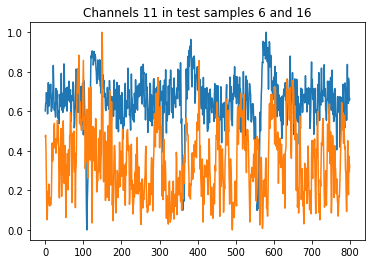

In [41]:
# inspect channel ___ sample
chan = 30
samp = 12
%matplotlib inline
plt.plot(range(0, 800), x_test[samp, chan,:,0], range(0,800), y_test[samp,0,:,0])
ax = plt.gca()
ax.set_title("Channels 11 in test samples 6 and 16")

12


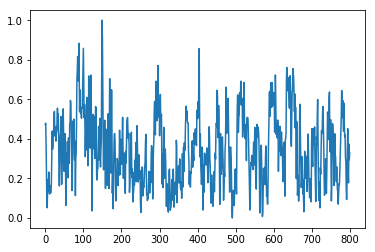

In [42]:
print(samp)
plt.plot(y_test[samp,0,:,0])

In [ ]:
# Training time!
# Try 20 epochs using batch size = 3, then switch to 4
model.fit(x_train, y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/home/amplifier/home/logs/CNN_autoenc_reconst')])

# save the entire model and the weights after the training:
model.save('/home/amplifier/home/models/EEGnet_stim_reconst.h5')
model.save_weights('/home/amplifier/home/weights/EEGnet_stim_reconst_weights.h5')

In [ ]:
# let's compute some predictions:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)
print("The shape of the decoded TRAINING samples' tensor", decoded_train.shape)
print("The shape of the decoded TEST samples' tensor", decoded_test.shape)

Test sample 0 : Correlation  [-0.02817558]  P-value:  [ 0.4261232]
Test sample 1 : Correlation  [-0.06385712]  P-value:  [ 0.07104796]
Test sample 2 : Correlation  [-0.12066752]  P-value:  [ 0.00062584]
Test sample 3 : Correlation  [-0.00561276]  P-value:  [ 0.87400317]
Test sample 4 : Correlation  [ 0.34031379]  P-value:  [  3.85373541e-23]
Test sample 5 : Correlation  [-0.01486668]  P-value:  [ 0.67459142]
Test sample 6 : Correlation  [ 0.13818924]  P-value:  [  8.80735824e-05]
Test sample 7 : Correlation  [-0.07329368]  P-value:  [ 0.03820862]
Test sample 8 : Correlation  [ 0.03372513]  P-value:  [ 0.34074634]
Test sample 9 : Correlation  [ 0.04543263]  P-value:  [ 0.19925474]
Test sample 10 : Correlation  [-0.02016326]  P-value:  [ 0.56903476]
Test sample 11 : Correlation  [ 0.01915395]  P-value:  [ 0.5885402]
Test sample 12 : Correlation  [ 0.22961327]  P-value:  [  4.95460756e-11]
Test sample 13 : Correlation  [ 0.0344271]  P-value:  [ 0.33079365]
Test sample 14 : Correlation  [-

Text(0.5,1,'Original')

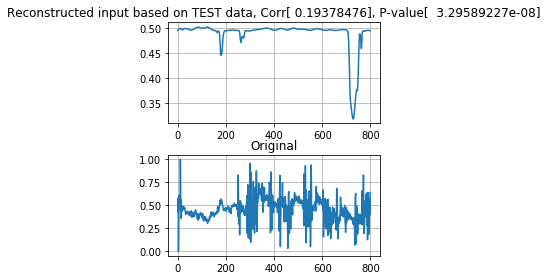

In [17]:
# set FALSE if you want to reconstruct the TEST samples:
reconstruct_training_sample = False

from scipy.stats import pearsonr


# now let's see how the model performs:
if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,:,:,:].reshape(800,1)
    orig = y_train[samp,:,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data, " + "Corr"+ str(R) + ", P-value" + str(p)
    for samp in range(y_train.shape[0]):
        reconst = decoded_train[samp,:,:,:].reshape(800,1)
        orig = y_train[samp,:,:,:].reshape(800,1)
        R,p = pearsonr(reconst, orig)
        print("Training sample", samp, ": Correlation ", R, " P-value: ", p)
    
else:
    reconst = decoded_test[samp,:,:,:].reshape(800,1)
    orig = y_test[samp,:,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TEST data, " + "Corr"+ str(R) + ", P-value" + str(p)
    for samp in range(y_test.shape[0]):
        reconst = decoded_test[samp,:,:,:].reshape(800,1)
        orig = y_test[samp,:,:,:].reshape(800,1)
        R,p = pearsonr(reconst, orig)
        print("Test sample", samp, ": Correlation ", R, " P-value: ", p)

print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.grid()
ax.set_title(title)
plt.subplot(212)
plt.plot(orig)
plt.tight_layout()
ax = plt.gca()
ax.grid()
ax.set_title("Original")

In [ ]:
# set FALSE if you want to reconstruct the TEST samples:
reconstruct_training_sample = True

from scipy.stats import pearsonr


# now let's see how the model performs:
if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,:,:,:].reshape(800,1)
    orig = y_train[samp,:,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data, " + "Corr"+ str(R) + ", P-value" + str(p)
    for samp in range(y_train.shape[0]):
        reconst = decoded_train[samp,:,:,:].reshape(800,1)
        orig = y_train[samp,:,:,:].reshape(800,1)
        R,p = pearsonr(reconst, orig)
        print("Training sample", samp, ": Correlation ", R, " P-value: ", p)
    
else:
    reconst = decoded_test[samp,:,:,:].reshape(800,1)
    orig = y_test[samp,:,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TEST data, " + "Corr"+ str(R) + ", P-value" + str(p)
    for samp in range(y_test.shape[0]):
        reconst = decoded_test[samp,:,:,:].reshape(800,1)
        orig = y_test[samp,:,:,:].reshape(800,1)
        R,p = pearsonr(reconst, orig)
        print("Test sample", samp, ": Correlation ", R, " P-value: ", p)

print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.grid()
ax.set_title(title)
plt.subplot(212)
plt.plot(orig)
plt.tight_layout()
ax = plt.gca()
ax.grid()
ax.set_title("Original")